In [ ]:
import os

# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')
!rm -rf data
!mkdir data
os.chdir('data')
!pwd

# Download data
!pip install -q kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Unzip data
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip train.csv

kaggle.json
/content/data
100% 285M/285M [00:11<00:00, 38.0MB/s]
100% 285M/285M [00:11<00:00, 26.6MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: train.csv               


In [ ]:
import csv
import numpy

train_images = []
train_labels = []

categories_count = {}

with open('train.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate categories count
        count = 0
        if label_str in categories_count:
            count = categories_count[label_str] + 1
        categories_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (28709, 48, 48)
y_train shape: (28709,)


In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(len(x_train), 48, 48, 1)
x_test = x_test.reshape(len(x_test), 48, 48, 1)

print(x_train.shape)
print(x_test.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

print('Tensorflow version: {}'.format(tf.__version__))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import Model, Input, callbacks

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Tensorflow version: 2.12.0


In [ ]:
# Perform data augmentation
data_generator = ImageDataGenerator(rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    horizontal_flip=True)
flow = data_generator.flow(x_train,
                           y_train,
                           batch_size=128)


In [2]:
with tf.device('/device:GPU:0'):
  base_model = tf.keras.applications.ResNet50(
    input_shape=(48, 48, 3),
    include_top=False,
    weights=None
)
with tf.device('/device:GPU:0'):
  model = Sequential()
  model.add(Conv2D(3, input_shape=(48, 48, 1), kernel_size=(1, 1), activation='relu'))
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.65))
  model.add(Dense(128,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(7,activation='softmax'))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 3)         6         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 2048)              0

Next, we will train our model. Here we use Early Stopping strategy, which will stop the training process when there is no improvement in the validation accuracy. Besides, we will also reduce the learning rate by a specific factor if there is a plateau is detected in the validation loss.

In [ ]:
class ADJUSTLR(callbacks.Callback):
    def __init__ (self, model, freq, factor, verbose):
        self.model=model
        self.freq=freq
        self.factor =factor
        self.verbose=verbose
        self.adj_epoch=freq
    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 == self.adj_epoch: # adjust the learning rate
            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
            new_lr=lr * self.factor
            self.adj_epoch +=self.freq
            if self.verbose == 1:
                print('\non epoch ',epoch + 1, ' lr was adjusted from ', lr, ' to ', new_lr)
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
freq=10
factor=.9
verbose=1
callbacks=[ADJUSTLR(model, freq, factor, verbose)]

with tf.device('/device:GPU:0'):
  history = model.fit(flow,
                      batch_size=128,
                      epochs=80,
                      validation_data=(x_test, y_test),
                      callbacks=callbacks)

Epoch 1/80
180/180 [==============================] - 79s 153ms/step - loss: 1.8142 - accuracy: 0.2616 - val_loss: 1.8831 - val_accuracy: 0.2524
Epoch 2/80
180/180 [==============================] - 16s 90ms/step - loss: 1.6761 - accuracy: 0.3382 - val_loss: 1.9541 - val_accuracy: 0.1769
Epoch 3/80
180/180 [==============================] - 17s 96ms/step - loss: 1.6013 - accuracy: 0.3756 - val_loss: 1.6804 - val_accuracy: 0.3516
Epoch 4/80
180/180 [==============================] - 18s 98ms/step - loss: 1.5346 - accuracy: 0.4023 - val_loss: 1.5703 - val_accuracy: 0.3990
Epoch 5/80
180/180 [==============================] - 18s 99ms/step - loss: 1.4707 - accuracy: 0.4320 - val_loss: 1.6948 - val_accuracy: 0.3292
Epoch 6/80
180/180 [==============================] - 17s 97ms/step - loss: 1.4264 - accuracy: 0.4506 - val_loss: 1.5858 - val_accuracy: 0.3774
Epoch 7/80
180/180 [==============================] - 22s 123ms/step - loss: 1.3688 - accuracy: 0.4781 - val_loss: 1.5053 - val_accurac

After the training process is completed, let's display the accuracy diagram of the training accuracy and validation accuracy.

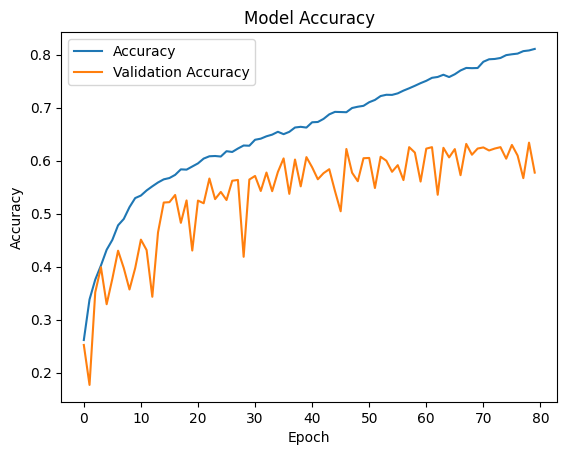

In [ ]:
# Show accuracy diagram
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

180/180 [==============================] - 3s 9ms/step


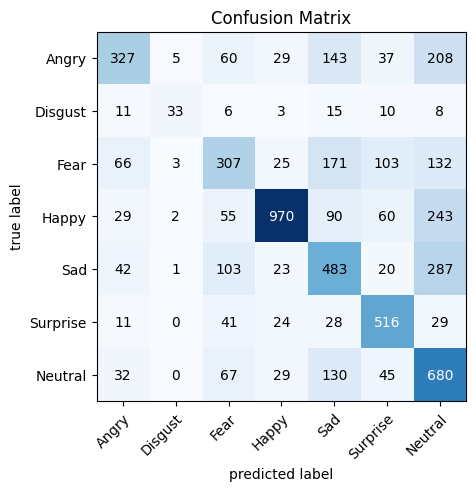

In [ ]:
!pip install -U mlxtend > /dev/null 2>&1

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Make predictions
predictions = model.predict(x_test)
y_predict = numpy.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Display confusion matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, class_names=class_names)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

180/180 [==============================] - 2s 10ms/step - loss: 1.4326 - accuracy: 0.5775


[1.432631015777588, 0.5774991512298584]